# Capital Allocation Line #

### Building Portfolios Maximizing Sharpe Ratio ###

In [2]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_financial_data
from portfolios_toolkit import portfolio_variance
from portfolios_toolkit import eff_coefficients
from portfolios_toolkit import eff_equation

# Pretty Notation
from IPython.display import display, Math

In [3]:
# Import Data

# Apple Data
df_1 = import_financial_data("AAPL")

# Amazon Data
df_2 =  import_financial_data("AMZN")

# Meta Data
df_3 =  import_financial_data("META")

# Microsoft Data
df_4 =  import_financial_data("MSFT")

In [4]:
# Create the joint dataframe

df_data = pd.DataFrame()

df_data['AAPL'] = df_1['adj_close']
df_data['AMZN'] = df_2['adj_close']
df_data['META'] = df_3['adj_close']
df_data['MSFT'] = df_4['adj_close']

df_data = df_data.dropna()

# Create the returns
df_returns = df_data.pct_change(1).mul(100)
df_returns = df_returns.apply(lambda x: x.fillna(x.mean()), axis=0)

df_returns

,AAPL,AMZN,META,MSFT
Date,,,,
2015-01-02,0.103109,0.122536,0.109293,0.104190
2015-01-05,-2.817159,-2.051731,-1.606119,-0.930282
2015-01-06,0.009412,-2.283332,-1.347325,-1.457097
2015-01-07,1.402221,1.059975,0.000000,1.270537
2015-01-08,3.842227,0.683600,2.659225,2.941813
...,...,...,...,...
2024-10-22,-0.262179,0.333210,1.190973,2.084627
2024-10-23,-2.162300,-2.630469,-3.147712,-0.680686
2024-10-24,-0.082337,0.904120,0.725576,0.030617


In [5]:
# Create the expected returns and standard deviations

expected_returns = df_returns.mean()
volatility = df_returns.dropna().std()
cov_matrix = df_returns.dropna().cov()

In [6]:
# Obtain the coefficients of the Efficient Frontier

coefficients = eff_coefficients(expected_returns, cov_matrix)

coefficients

(79.49940285135305, 1444.3210787826313, 6775.50511775446)

In [7]:
# Create a rango of values for mu_P
mu_P_values = np.linspace(0.1025, 0.123, 400)

# Evaluate the equation for mu_P values
sigma_P_values = eff_equation(coefficients, mu_P_values).reshape(-1, 1)

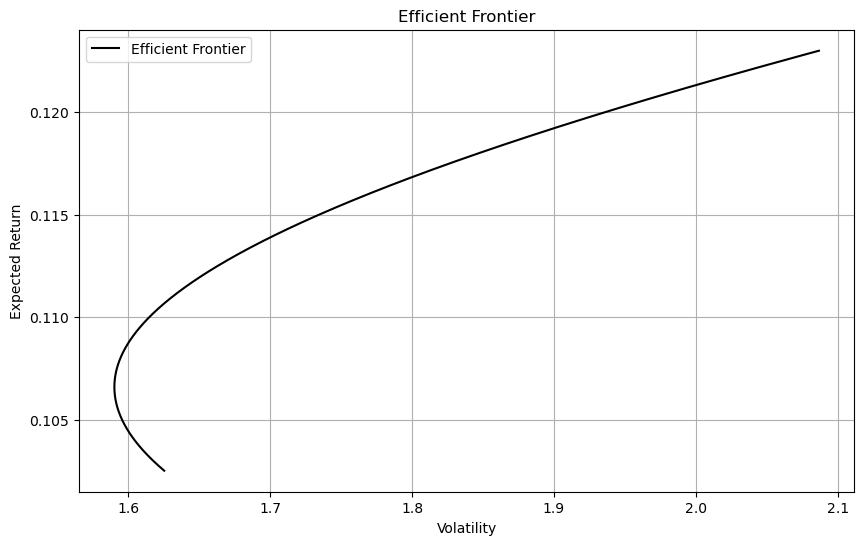

In [8]:
# Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')


# Config
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [9]:
# The Most Efficient Portfolio is that which maximizes the Sharp Ratio

rfr = 0.000125

In [10]:
# Tangency Returns

display(Math(r"\mu_T = \frac{2\pi_0 - \pi_1r_f}{\pi_1 - 2\pi_2r_f}"))

<IPython.core.display.Math object>

In [11]:
# Obtain the values
pi_0 = coefficients[0]
pi_1 = coefficients[1]
pi_2 = coefficients[2]

tangency_returns = ((2*pi_0 - pi_1*rfr)/(pi_1 - 2*pi_2*rfr))
tangency_volat = eff_equation(coefficients, tangency_returns)

print(f"The Tangency Portfolio Returns are: {tangency_returns}")
print(f"The Tangency Portfolio Volatility is: {tangency_volat}")

The Tangency Portfolio Returns are: 0.11008960963184583
The Tangency Portfolio Volatility is: 1.6161369220174138


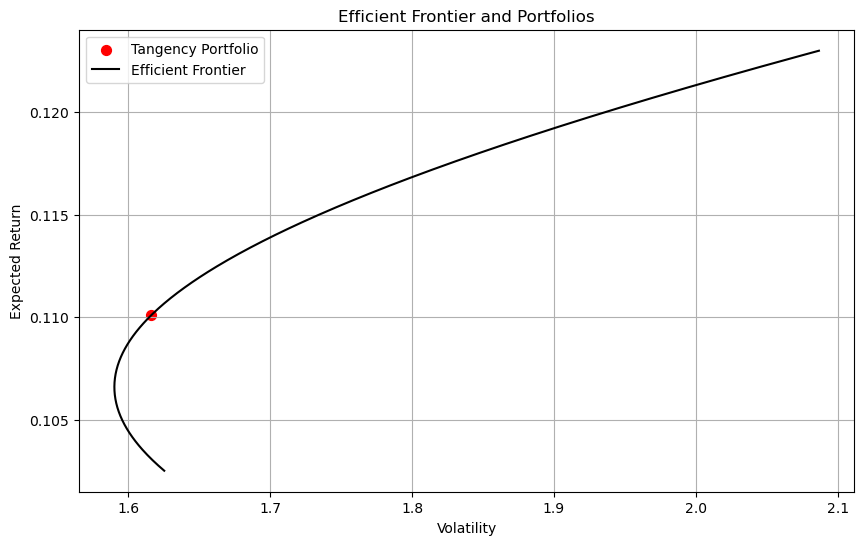

In [12]:
# Create the Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(tangency_volat, tangency_returns, color='red', s=50, label='Tangency Portfolio')  
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')


# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [13]:
# The Maximum Sharpe Ratio is the slope of the capital allocation line

sharpe_ratio = (tangency_returns - rfr)/tangency_volat

print(f"The Maximum Sharpe Ratio is: {sharpe_ratio}")

The Maximum Sharpe Ratio is: 0.06804164185208868


In [14]:
# Define the CAL

def CAL(rfr, sigma_P):
    return rfr + sharpe_ratio*sigma_P

# Create Range for Sigma
sigma_cal_values = np.linspace(1.5, 1.9, 400)

# Evaluate for each values of sigma
mu_cal_values = CAL(rfr, sigma_cal_values).reshape(-1, 1)

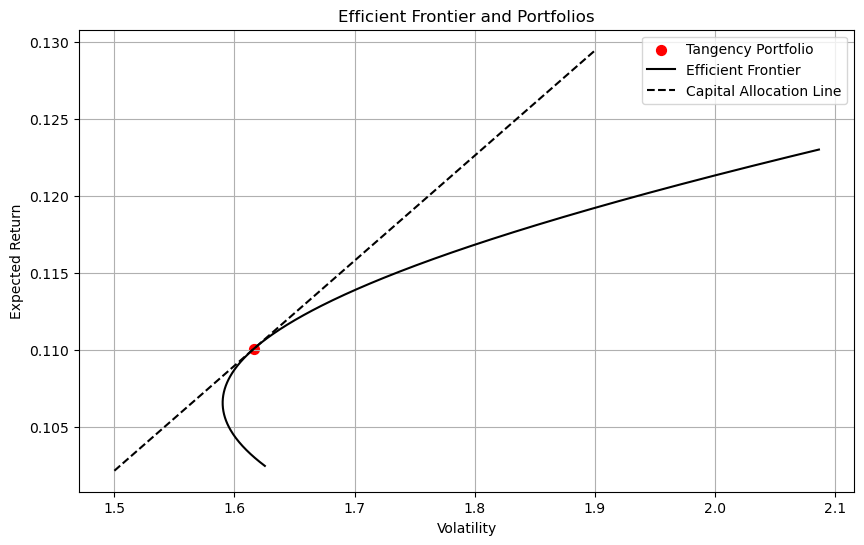

In [15]:
# Create Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(tangency_volat, tangency_returns, color='red', s=50, label='Tangency Portfolio')  
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')
plt.plot(sigma_cal_values, mu_cal_values, label=r'Capital Allocation Line', color='black', linestyle='--')

# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [16]:
# Obtain the Weights of the Tangency Portfolio

def weights(desired_returns):
    # Number of assets
    n = len(expected_returns)
    
    # Create inputs
    mu = expected_returns.values.flatten().reshape(-1, 1)  # Expected Returns
    Sigma = cov_matrix.values  # Covariance Matrix
    Sigma_inv = np.linalg.inv(Sigma)  # Inverse Covariance Matrix
    iota = np.ones((n, 1))  # Vector of Ones

    # Create components
    A = np.dot(np.dot(mu.T, Sigma_inv), mu)
    B = np.dot(np.dot(iota.T, Sigma_inv), mu)
    C = np.dot(np.dot(iota.T, Sigma_inv), iota)
    D = (A * C - B * B)

    # Calculate the weights
    first_part = (((desired_returns * C) - B) / D) * (Sigma_inv @ mu)
    second_part = ((A - (desired_returns * B)) / D) * (Sigma_inv @ iota)

    return first_part + second_part 

tangency_weights = weights(tangency_returns)

tangency_weights

array([[0.30022602],
       [0.33194044],
       [0.02629675],
       [0.34153679]])

In [37]:
# Now let us assume we there is an investor willing to take more risk to reach better returns

cal_returns = 0.125

#In a normal case

normal_case_weights = weights(cal_returns)

print(normal_case_weights)

print(f'The sum of weights is: {normal_case_weights.sum().round(2)}')

[[ 0.02886853]
 [ 1.14453709]
 [-0.03077028]
 [-0.14263534]]
The sum of weights is: 1.0


In [38]:
# Define the function to obtain the weights for the CAL

def cal_weights(desired_returns):
    
    # Create inputs
    mu = expected_returns.values.flatten().reshape(-1, 1)  # Expected Returns
    Sigma = cov_matrix.values  # Covariance Matrix
    Sigma_inv = np.linalg.inv(Sigma)  # Inverse Covariance Matrix

    # Create components
    A = np.dot(np.dot(mu.T, Sigma_inv), mu)

    weights = ((desired_returns - rfr) / A) * (Sigma_inv @ mu)

    return weights

cal_weights = cal_weights(cal_returns)

print(cal_weights)

print(f'The sum of weights is: {cal_weights.sum().round(2)}')

if cal_weights.sum().round(2) < 1:
    print('You are a lender')
elif cal_weights.sum().round(2) > 1:
    print('You are a borrower')
else:
    print('You are special')

[[0.34064494]
 [0.37628101]
 [0.02984745]
 [0.38757219]]
The sum of weights is: 1.13
You are a borrower


In [45]:
# Obtain the volatility given the desired returns

def cal_volatility(desired_returns):
    # Create inputs
    mu = expected_returns.values.flatten().reshape(-1, 1)  # Expected Returns
    Sigma = cov_matrix.values  # Covariance Matrix
    Sigma_inv = np.linalg.inv(Sigma)  # Inverse Covariance Matrix

    # Create components
    A = np.dot(np.dot(mu.T, Sigma_inv), mu)
    
    return abs(np.sqrt(1/A)*(desired_returns - rfr))

cal_volat = cal_volatility(cal_returns)

print(f'The CAL Portfolio Risk: {cal_volat[0][0]}')

The CAL Portfolio Risk: 1.8331892948663449


In [46]:
cal_var = portfolio_variance(cal_weights, df_returns[['AAPL', 'AMZN', 'META', 'MSFT']])
cal_volat_alt = np.sqrt(cal_var)

print(cal_volat_alt[0][0])

1.8331892948663453


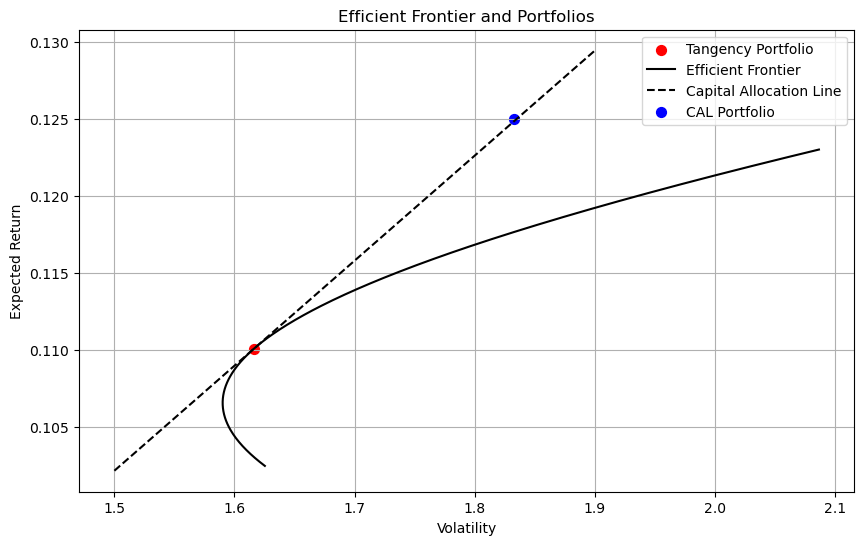

In [41]:
# Create Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tangency_volat, tangency_returns, color='red', s=50, label='Tangency Portfolio')  
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')
plt.plot(sigma_cal_values, mu_cal_values, label=r'Capital Allocation Line', color='black', linestyle='--')
plt.scatter(cal_volat, cal_returns, color='blue', s=50, label='CAL Portfolio')  


# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [42]:
# Create Portfolios
tangency_portfolio = df_returns[['AAPL', 'AMZN', 'META', 'MSFT']] @ tangency_weights
cal_portfolio = df_returns[['AAPL', 'AMZN', 'META', 'MSFT']] @ cal_weights

# Create DataFrame
df_returns['Tangency Portfolio'] = tangency_portfolio
df_returns['CAL Portfolio'] = cal_portfolio

df_returns

,AAPL,AMZN,META,MSFT,Tangency Portfolio,CAL Portfolio
Date,,,,,,
2015-01-02,0.103109,0.122536,0.109293,0.104190,0.110090,0.124875
2015-01-05,-2.817159,-2.051731,-1.606119,-0.930282,-1.886798,-2.140168
2015-01-06,0.009412,-2.283332,-1.347325,-1.457097,-1.288187,-1.460913
2015-01-07,1.402221,1.059975,0.000000,1.270537,1.206767,1.368933
2015-01-08,3.842227,0.683600,2.659225,2.941813,2.455117,2.785597
...,...,...,...,...,...,...
2024-10-22,-0.262179,0.333210,1.190973,2.084627,0.775188,0.879562
2024-10-23,-2.162300,-2.630469,-3.147712,-0.680686,-1.837592,-2.084138
2024-10-24,-0.082337,0.904120,0.725576,0.030617,0.304932,0.345679


In [43]:
def calculate_analytics(df_returns, risk_free_rate=0.0):
    # Trading Days in one Year
    ann_factor = 252  
    
    # Annualized Returns
    annualized_return = df_returns.mean() * ann_factor
    
    # Annualized Volatility
    annualized_std = df_returns.std() * np.sqrt(ann_factor)
    
    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std
    
    # Max Drawdown
    cumulative_returns = (1 + df_returns.div(100)).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / rolling_max) - 1
    max_drawdown = drawdown.min()

    # VaR at 95%
    var_95 = df_returns.quantile(0.05)

    # Create DF
    summary_df = pd.DataFrame({
        "Annualized Returns": annualized_return,
        "Annualized Volatility": annualized_std,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "VaR 95%": var_95
    })
    
    return summary_df

In [44]:
# Now the table
analytics_table = calculate_analytics(df_returns)

analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
AAPL,25.983505,28.639845,0.907250,-0.387297,-2.713460
AMZN,30.879190,32.778793,0.942048,-0.561453,-3.061348
META,27.541784,37.632035,0.731871,-0.767361,-3.317563
MSFT,26.255872,27.209956,0.964936,-0.375565,-2.646305
Tangency Portfolio,27.742582,25.655378,1.081355,-0.395505,-2.572526
CAL Portfolio,31.468500,29.100978,1.081355,-0.441065,-2.918019
